In [1]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

In [2]:
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)
mp = ground_truth

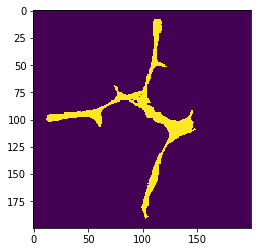

In [3]:
plt.imshow(mp)

In [4]:
mp.shape

(200, 200)

In [5]:
#min x which is unblocked
def get_min_x_unblocked(mp):
    for i in range(199, -1, -1):
        for j in range(199, -1, -1):
            if mp[i, j] > 0.0:
                return i, j
lowest_ub = get_min_x_unblocked(mp)
print(lowest_ub)

(191, 103)


In [6]:
def is_on_border(mp, pos):
    for di in range(-1, 2):
        for dj in range(-1, 2):
            if mp[pos[0] + di, pos[1] + dj] == 0.0:
                return True
    return False
is_on_border(mp, lowest_ub)

True

In [7]:
is_on_border(mp, (107, 130))

False

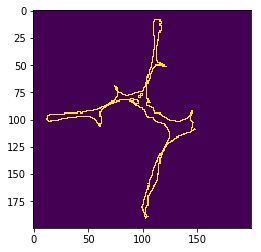

In [8]:
def build_border_map(mp):
    border_mp = np.copy(mp)
    for i in range(mp.shape[0]):
        for j in range(mp.shape[1]):
            if mp[i, j] > 0.0 and not is_on_border(mp, (i, j)):
                border_mp[i, j] = 0.0
    return border_mp
plt.imshow(build_border_map(mp))

In [11]:
def traverse_border(border_map, border_path, current, prev):
    next_border_pos = []
    border_path.append(current)
    found_next = False
    new_pos = None
    for di in range(-1, 2):
        if found_next:
            break
        for dj in range(-1, 2):
            new_pos = (current[0] + di, current[1] + dj)
            if border_map[current[0] + di, current[1] + dj] == 1.0:
                found_next = True
                if not new_pos in border_path:
                    break
    
    #print (current)
    prev = current
    current = new_pos

    if found_next:
        traverse_border(border_map, border_path, current, prev)
    return border_path
                    
def build_border_path(border_map):
    lowest_ub = get_min_x_unblocked(border_map)
    path = []
    border_path = traverse_border(border_map, path, lowest_ub, None)
    return border_path

bpath = build_border_path(build_border_map(mp))
len(bpath)

136

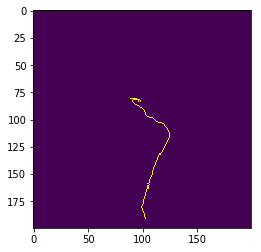

In [12]:
border_path_map = np.zeros(mp.shape)
for pos in bpath:
    border_path_map[pos[0], pos[1]] = 1.0
    
plt.imshow(border_path_map)

In [46]:
DIST_FROM_WALL = 2

def median_path(mp, left_right = True):
    lmeans = []
    rmeans = []
    border_mp = np.copy(mp)
    for i in range(mp.shape[0]):
        start = None
        end = None
        inside = False
        for j in range(mp.shape[1]):
            if left_right == True:
                pos = (i, j)
            else:
                pos = (j, i)
            if mp[pos] == 1.0 and not inside:
                inside = True
                start = j
            if mp[pos] == 0.0 and inside:
                inside = False
                end = j
            if start != None and end != None:
                wh = start + DIST_FROM_WALL
                if left_right == True:
                    new_pos = (i, wh)
                else:
                    new_pos = (wh, i)
                if mp[new_pos] == 1.0:
                    lmeans.append(new_pos)
                
                wh = end - DIST_FROM_WALL
                if left_right == True:
                    new_pos = (i, wh)
                else:
                    new_pos = (wh, i)
                if mp[new_pos] == 1.0:
                    rmeans.append(new_pos)
                
                start = None
                end = None
    return lmeans + rmeans

lrmedians = median_path(mp)
upmedians = median_path(mp, False)

medians = lrmedians + upmedians

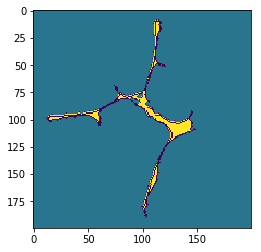

In [47]:
median_path_map = np.zeros(mp.shape)

median_path_map.fill(255)

for i in range(median_path_map.shape[0]):
    for j in range(median_path_map.shape[1]):
        if is_on_border(mp, (i, j)):
            median_path_map[i, j] = 100
for pos in medians:
    median_path_map[pos[0], pos[1]] = 1

plt.imshow(median_path_map)

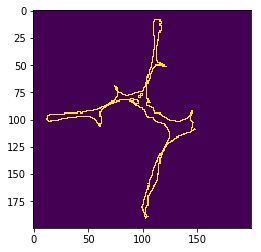

In [17]:
plt.imshow(build_border_map(mp))

In [105]:
def distance(pos1, pos2):
    return np.sqrt(np.square(pos1[0] - pos2[0]) + np.square(pos1[1] - pos2[1]))

def sign_changes(start, end, new_pos):
    sc = 0
    if np.sign(new_pos[0] - end[0]) != np.sign(end[0] - start[0]):
        sc += 1
    if np.sign(new_pos[1] - end[1]) != np.sign(end[1] - start[1]):
        sc += 1
    return sc

def find_min_not_visited(prev, pos, not_visited):
    min_dist = None
    min_pos = None
    min_sc = None
    for sc in range(3):
        for to in not_visited:
            dc = sign_changes(prev, pos, to)
            dist = distance(pos, to)
            if min_dist == None or (dc == sc and dist < min_dist and dist > 1):
                min_dist = dist
                min_pos = to
                min_sc = dc
        if min_dist != None and min_dist < 5:
            break
    if min_dist != None and min_dist < 30:
        #print(min_dist, prev, pos, min_pos, min_sc)
        return min_pos
    else:
        return None

def greedy_path(current_path):
    #visited = set([])
    new_path = []
    not_visited = set(current_path)
    current = current_path[0]
    prev = current
    while current != None and current in not_visited:
        not_visited.discard(current)
        new_path.append(current)
        prev = current
        current = find_min_not_visited(prev, current, not_visited)
    print('not visited', len(not_visited))
    return new_path

apath = greedy_path(medians)
print('path length', len(apath))

not visited 280
path length 468


In [103]:
def create_path_images(path):
    path_images = []
    mp_3d = np.dstack((mp*0, mp*100, mp*0)).astype(np.float)

    for i in range(len(path)):
        new_mp = np.copy(mp_3d)
        for j in range(i):
            median = path[j]
            new_mp[median[0], median[1], 0] = 255
            new_mp[median[0], median[1], 1] = 0
            new_mp[median[0], median[1], 2] = 255
        path_images.append(new_mp)
    return path_images

path_images = create_path_images(apath)

In [104]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

# Define pathname to save the output video
output = '../output/test_path.mp4'
clip = ImageSequenceClip(path_images, fps=60) # Note: output video will be sped up because 
# recording rate in simulator is fps=25
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/test_path.mp4
[MoviePy] Writing video ../output/test_path.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:00<00:00, 1081.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_path.mp4 

Wall time: 499 ms


In [100]:
from IPython.display import HTML
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))